In [12]:
import numpy as np
import wfdb
import pandas as pd
from glob import glob
import os
import biosppy
import pyhrv
import pyhrv.tools as tools
import json
import shap

## Data Pre-processing

In [3]:
data_dir = "data/CPSC/"
recordpaths = glob(os.path.join(data_dir, '*.hea'))

for recordpath in recordpaths:
    patient_id = recordpath.split('/')[-1][:-4]
    signals, meta_data = wfdb.rdsamp(recordpath[:-4])
    sample_rate = meta_data['fs']
    signal_len = meta_data['sig_len']
    age = meta_data['comments'][0]
    sex = meta_data['comments'][1]
    dx = meta_data['comments'][2]
    age = age[5:] if age.startswith('Age: ') else np.NaN
    sex = sex[5:] if sex.startswith('Sex: ') else 'Unknown'
    dx = dx[4:] if dx.startswith('Dx: ') else ''


    folder_path = f"processing/{patient_id}/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
        for signal in signals.T:
            try:
                # Get R-peaks series using biosppy
                t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(signal, sampling_rate=500, show=False)[:3]
            except:
                pass
            try:
                HRV_params = pyhrv.hrv(rpeaks=t[rpeaks])
            except:
                pass

            tools.hrv_export(HRV_params, path=folder_path)
    
        df_combined = pd.DataFrame()

        # Loop over each iteration of your for loop
        for filename in os.listdir(folder_path): 

            # Open the current file for reading
            with open(os.path.join(folder_path, filename)) as f:

                # Load the JSON data from the file into a Python object
                data = json.load(f)

                # Convert the Python object to a pandas DataFrame
                df = pd.json_normalize(data)

                # Select columns with at most one value
                cols_with_single_value = [col for col in df.columns if df[col].apply(lambda x: len(x) if isinstance(x, list) else 1).max() <= 1]
                df_with_single_value = df[cols_with_single_value].drop(columns=['Comment', 'Name'])
                df_with_single_value = df_with_single_value.dropna(axis=1)
                df_with_single_value = df_with_single_value._get_numeric_data()

                # Write the data to the combined JSON file

            df_combined = df_combined.append(df_with_single_value, ignore_index=True)

        df_combined.to_csv(f"csv/{patient_id}.csv", index=False)

## HRV Features preparation

In [4]:
# set the path of the directory where csv files are located
directory_path = 'csv'

# create an empty list to store the dataframes for each file
dfs = []
#patient_ids = []
leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# loop through each file in the directory
for file in os.listdir(directory_path):
        
        if file.endswith('.csv'):
            patient_id = file[:-4]
            file_path = os.path.join(directory_path, file)


            # read the csv file into a dataframe
            df = pd.read_csv(file_path)
            
            if len(df.T) > 39:
                df = df.drop(["dfa_alpha1", "dfa_alpha2"], axis=1)

            cols = df.columns.tolist()

            # reshape the dataframe to have 1 row and 12*39 columns
            datalist = df.values.reshape((1, -1))


            col_names = []

            for lead in leads:
                for col in cols:
                    col_names.append(col + "_" + lead)
                    
            #datalist = datalist.insert(0, patient_id)
                    
            df = pd.DataFrame(datalist, columns=col_names)
            df.insert(0, "patient_id", patient_id)
            
            dfs.append(df)
            
#result = pd.concat(dfs, axis=0, index=patient_ids)
result = pd.concat(dfs, axis=0, ignore_index=True)
result.sort_values(by=["patient_id"], ascending=True, inplace=True)

result.to_csv("hrv_features.csv", index=False)

In [5]:
df = pd.read_csv("hrv_features.csv")

# Check for duplicate columns and drop them
df = df.loc[:,~df.T.duplicated(keep='first')]

# Rename the remaining column
#df = df.rename(columns={'A': 'new_column_name'})
df.to_csv("hrv_features_no_duplicates.csv", index=False)

In [13]:
def split_data(seed=42):
    folds = range(1, 11)
    folds = np.random.RandomState(seed).permutation(folds)
    return folds[:8], folds[8:]

Machine Learning classifers and application

In [15]:
classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']

df_labels = pd.read_csv("labels.csv")
df_X = pd.read_csv("hrv_features_no_duplicates.csv")

sel_ids = df_X["patient_id"].tolist()

df_labels = df_labels[df_labels['patient_id'].isin(sel_ids)]

df_X.replace([np.inf, -np.inf], 10000, inplace=True)
df_X = df_X.merge(df_labels[['patient_id', 'fold']], on='patient_id')
train_folds, test_folds = split_data()
feature_cols = df_X.columns[1:-1] # remove patient id and fold

X_train = df_X[df_X['fold'].isin(train_folds)][feature_cols].to_numpy()
X_test = df_X[df_X['fold'].isin(test_folds)][feature_cols].to_numpy()

# Preprocess the data using standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = df_labels[df_labels['fold'].isin(train_folds)][classes].to_numpy()
y_test = df_labels[df_labels['fold'].isin(test_folds)][classes].to_numpy()

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score
import wfdb

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pickle

Start training RF...
Optimal Threshold: 0.15
SNR Accuracy: 0.6805860805860806, F1_score: 0.38935574229691877
Optimal Threshold: 0.25
AF Accuracy: 0.9487179487179487, F1_score: 0.8801369863013698
Optimal Threshold: 0.12
IAVB Accuracy: 0.6102564102564103, F1_score: 0.2830188679245283
Optimal Threshold: 0.04
LBBB Accuracy: 0.6175824175824176, F1_score: 0.11824324324324326
Optimal Threshold: 0.32
RBBB Accuracy: 0.6454212454212455, F1_score: 0.5071283095723015
Optimal Threshold: 0.21
PAC Accuracy: 0.8652014652014652, F1_score: 0.5257731958762887
Optimal Threshold: 0.17
PVC Accuracy: 0.8703296703296703, F1_score: 0.5795724465558194
Optimal Threshold: 0.17
STD Accuracy: 0.6593406593406593, F1_score: 0.32116788321167883
Optimal Threshold: 0.08
STE Accuracy: 0.802930402930403, F1_score: 0.14057507987220447


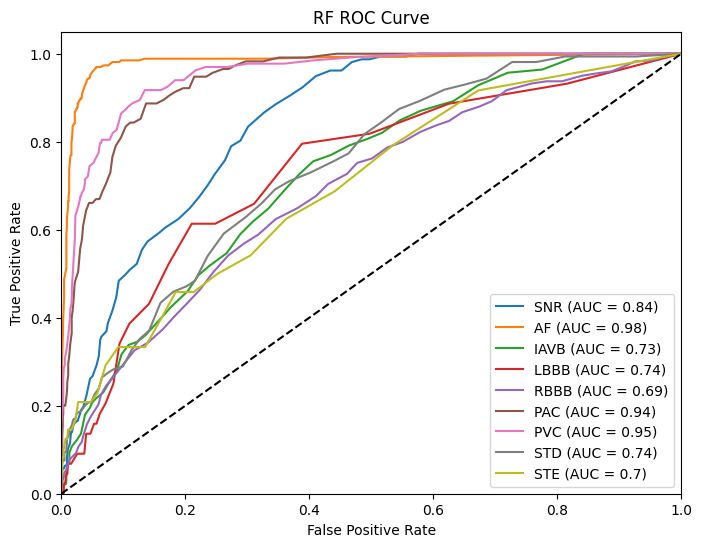

Start training DT...
Optimal Threshold: 1.0
SNR Accuracy: 0.8249084249084249, F1_score: 0.3151862464183381
Optimal Threshold: 1.0
AF Accuracy: 0.9186813186813186, F1_score: 0.7844660194174758
Optimal Threshold: 1.0
IAVB Accuracy: 0.8175824175824176, F1_score: 0.19935691318327975
Optimal Threshold: 1.0
LBBB Accuracy: 0.9296703296703297, F1_score: 0.09433962264150943
Optimal Threshold: 1.0
RBBB Accuracy: 0.6263736263736264, F1_score: 0.35279187817258884
Optimal Threshold: 1.0
PAC Accuracy: 0.8974358974358975, F1_score: 0.4214876033057851
Optimal Threshold: 1.0
PVC Accuracy: 0.8893772893772893, F1_score: 0.43445692883895126
Optimal Threshold: 1.0
STD Accuracy: 0.8043956043956044, F1_score: 0.247887323943662
Optimal Threshold: 1.0
STE Accuracy: 0.9296703296703297, F1_score: 0.09433962264150944


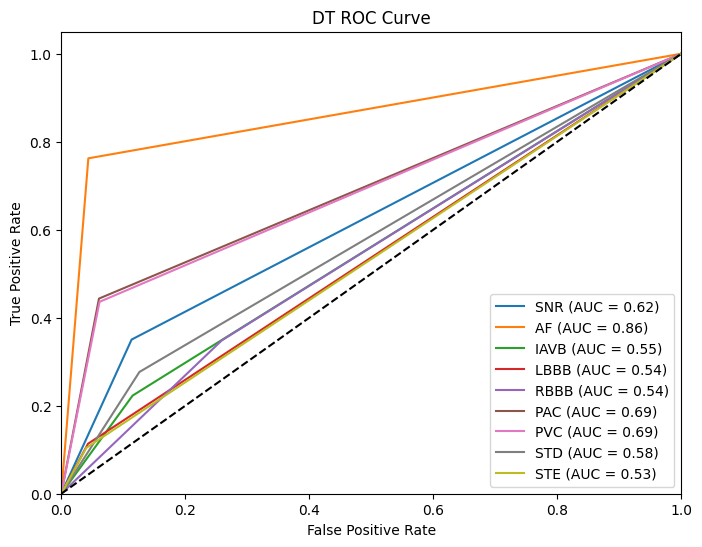

Start training LR...
Optimal Threshold: 0.07109200356176228
SNR Accuracy: 0.610989010989011, F1_score: 0.3625450180072029
Optimal Threshold: 0.25095868660632814
AF Accuracy: 0.9457875457875458, F1_score: 0.8706293706293707
Optimal Threshold: 0.06955726395441789
IAVB Accuracy: 0.5655677655677656, F1_score: 0.27946537059538273
Optimal Threshold: 0.02404382553063869
LBBB Accuracy: 0.621978021978022, F1_score: 0.0851063829787234
Optimal Threshold: 0.24774902663970105
RBBB Accuracy: 0.5802197802197803, F1_score: 0.48884924174843886
Optimal Threshold: 0.04999114198614256
PAC Accuracy: 0.7721611721611722, F1_score: 0.40761904761904766
Optimal Threshold: 0.06064400400549441
PVC Accuracy: 0.8051282051282052, F1_score: 0.45267489711934156
Optimal Threshold: 0.10355309802945367
STD Accuracy: 0.5985347985347985, F1_score: 0.3080808080808081
Optimal Threshold: 0.020507386166565004
STE Accuracy: 0.5772893772893772, F1_score: 0.11638591117917306


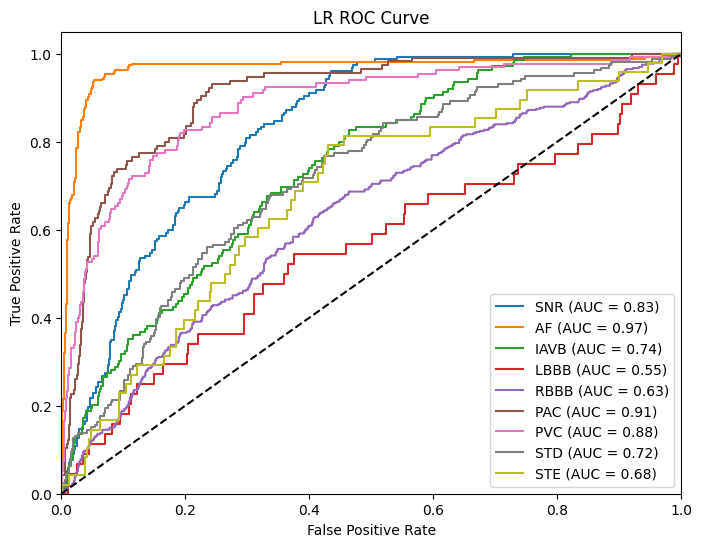

Start training SVM...
Optimal Threshold: 0.11665873212544765
SNR Accuracy: 0.5641025641025641, F1_score: 0.3246311010215664
Optimal Threshold: 0.22610992427324425
AF Accuracy: 0.9582417582417583, F1_score: 0.8976660682226212
Optimal Threshold: 0.10583371526373392
IAVB Accuracy: 0.6256410256410256, F1_score: 0.2583454281567489
Optimal Threshold: 0.03993026467939508
LBBB Accuracy: 0.7655677655677655, F1_score: 0.10614525139664804
Optimal Threshold: 0.2595134685895552
RBBB Accuracy: 0.6285714285714286, F1_score: 0.42189281641961224
Optimal Threshold: 0.07596258591798914
PAC Accuracy: 0.8446886446886447, F1_score: 0.49038461538461536
Optimal Threshold: 0.0711245129743593
PVC Accuracy: 0.8534798534798534, F1_score: 0.54337899543379
Optimal Threshold: 0.11836367913720076
STD Accuracy: 0.6051282051282051, F1_score: 0.2626538987688099
Optimal Threshold: 0.031982515276680924
STE Accuracy: 0.5245421245421246, F1_score: 0.09483960948396095


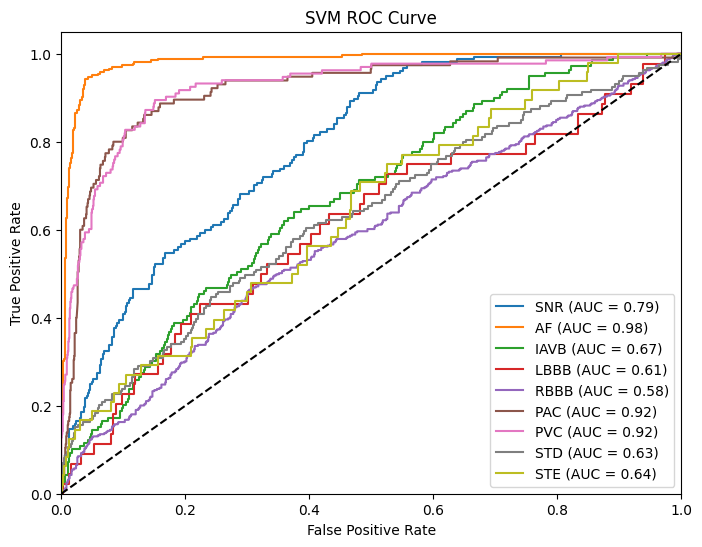

Start training LinerSVC...
Optimal Threshold: 4.574376377201705e-06
SNR Accuracy: 0.5992673992673992, F1_score: 0.34803337306317045
Optimal Threshold: 0.011130423260103833
AF Accuracy: 0.9267399267399268, F1_score: 0.8338870431893688
Optimal Threshold: 0.01415319971438151
IAVB Accuracy: 0.7347985347985349, F1_score: 0.3143939393939394
Optimal Threshold: 0.0007802902543329923
LBBB Accuracy: 0.7677655677655678, F1_score: 0.12672176308539945
Optimal Threshold: 0.028322721533807188
RBBB Accuracy: 0.5435897435897435, F1_score: 0.48126561199000834
Optimal Threshold: 0.026917505422378543
PAC Accuracy: 0.8981684981684982, F1_score: 0.5696594427244582
Optimal Threshold: 0.00957194366006026
PVC Accuracy: 0.8857142857142857, F1_score: 0.5894736842105263
Optimal Threshold: 0.00015600984936988357
STD Accuracy: 0.5274725274725275, F1_score: 0.28412874583795783
Optimal Threshold: 1.0674052591847541e-07
STE Accuracy: 0.42857142857142855, F1_score: 0.09722222222222222


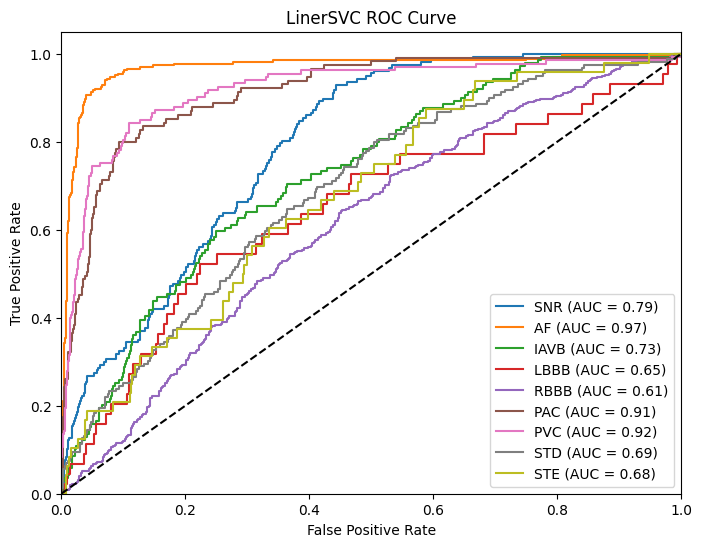

Start training MLP...


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Optimal Threshold: 0.000256249047678516
SNR Accuracy: 0.6329670329670329, F1_score: 0.35851472471190776
Optimal Threshold: 0.030057166908764258
AF Accuracy: 0.926007326007326, F1_score: 0.8267581475128645
Optimal Threshold: 0.0003024339082723122
IAVB Accuracy: 0.5714285714285714, F1_score: 0.26229508196721313
Optimal Threshold: 3.5475187089457884e-08
LBBB Accuracy: 0.38168498168498166, F1_score: 0.08061002178649238
Optimal Threshold: 0.01303505440133315
RBBB Accuracy: 0.5611721611721612, F1_score: 0.49021276595744684
Optimal Threshold: 2.4443224956199854e-05
PAC Accuracy: 0.8043956043956044, F1_score: 0.4233261339092873
Optimal Threshold: 0.0006559111350987275
PVC Accuracy: 0.841025641025641, F1_score: 0.5145413870246085
Optimal Threshold: 0.0032324716232979074
STD Accuracy: 0.5963369963369963, F1_score: 0.2721268163804491
Optimal Threshold: 4.240513107351047e-07
STE Accuracy: 0.4945054945054945, F1_score: 0.1038961038961039


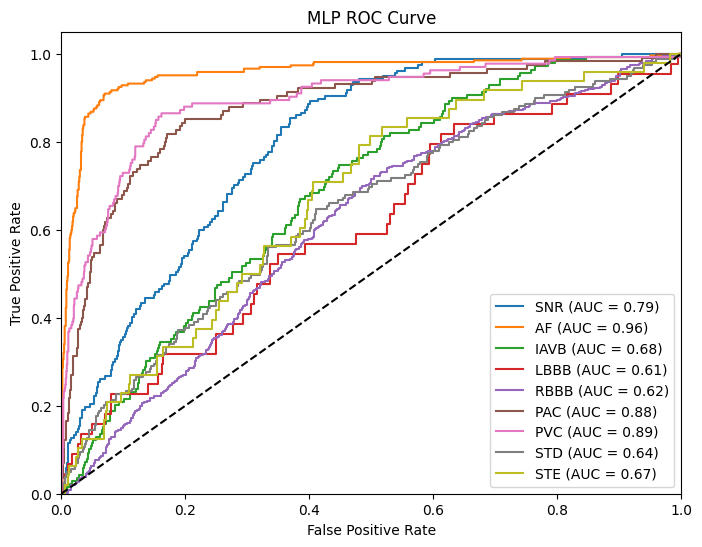

In [11]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
classifiers = ['RF', 'DT', 'LR', 'SVM', 'LinerSVC', 'MLP']
classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']

for classifier in classifiers:
    # tune parameters
    if classifier == 'LR':
        model = LogisticRegression(max_iter=2000)#solver='lbfgs', max_iter=1000)
    elif classifier == 'RF':
        model = RandomForestClassifier()#n_estimators=300, max_depth=10)
    elif classifier == 'SVM':
        model = SVC(probability=True)
    elif classifier == 'LinearSVC':
        model = LinearSVC()
    elif classifier == 'DT':
        model = DecisionTreeClassifier()
    else:
        model = MLPClassifier(max_iter=500) #hidden_layer_sizes=(100, 50), max_iter=500)
    if classifier != 'MLP':
        model = OneVsRestClassifier(model)

    print(f'Start training {classifier}...')
    model.fit(X_train, y_train)
    with open(f'models/model_{classifier}.pkl', 'wb') as file:
        pickle.dump(model, file)
    

    #y_val_scores = model.predict_proba(X_val)
    y_test_scores = model.predict_proba(X_test)
    roc_auc = dict()
    fpr = dict()
    tpr = dict()
    optimal_thresholds = []

    
    plt.figure(figsize=(8,6))
    
    for i in range(len(classes)):
        fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], y_test_scores[:, i])
        opt_threshold = thresholds[np.argmax(tpr[i]-fpr[i])]
        optimal_thresholds.append(opt_threshold)
        acc = accuracy_score(y_test[:, i], y_test_scores[:, i]>=opt_threshold)
        f1s = f1_score(y_test[:, i], y_test_scores[:, i]>=opt_threshold)
        print('Optimal Threshold:', opt_threshold)
        print(f'{classes[i]} Accuracy: {acc}, F1_score: {f1s}')
        roc_auc[classes[i]] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[classes[i]]:0.2})')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier} ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'results/roc_{classifier}')
    plt.show()
    plt.close()
   # plot_confusion_matrix(y_test, y_test_scores, classes, optimal_thresholds, classifier=classifier)

In [ ]:
def plot_cm(y_trues, y_preds, normalize=True, cmap=plt.cm.Blues, classifier=classifier):
    classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
    for i, label in enumerate(classes):
        y_true = y_trues[:, i]
        y_pred = y_preds[:, i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        opt_threshold = thresholds[np.argmax(tpr-fpr)]
        cm = confusion_matrix(y_true, y_pred >= opt_threshold)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig, ax = plt.subplots(figsize=(4, 4))
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)        
        ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=[0, 1], yticklabels=[0, 1],
           title=label,
           ylabel='True label',
           xlabel='Predicted label')
        plt.setp(ax.get_xticklabels(), ha="center")

        fmt = '.3f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        np.set_printoptions(precision=3)
        fig.tight_layout()
        plt.show()
        plt.savefig(f'results/{label}_{classifier}.png')
        plt.close()


if __name__ == "__main__":
    
    classifiers = ['RF', 'LR', 'LinerSVC', 'MLP']

    for classifier in classifiers:
        # tune parameters
        if classifier == 'RF':
            model = RandomForestClassifier() #n_estimators=300, max_depth=10)
        elif classifier == 'LR':
            model = LogisticRegression(max_iter=2000) #solver='lbfgs', max_iter=1000)
        elif classifier == 'LinearSVC':
            model = LinearSVC()
        else:
            model = MLPClassifier(max_iter=500) # hidden_layer_sizes=(100, 50), max_iter=500)
        if classifier != 'MLP':
            model = OneVsRestClassifier(model)

        print(f'Start training {classifier}...')
        model.fit(X_train, y_train)

        #y_val_scores = model.predict_proba(X_val)
        y_test_scores = model.predict_proba(X_test)
        # plot confusion matrix
        plot_cm(y_test, y_test_scores, classifier)